# Modeling of Yelp dataset

In [3]:
random_state = 0

In [28]:
import pandas as pd
import matplotlib
import seaborn as sns
import os
import sys
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from time import time

In [29]:
sys.path.append('../../src/')
from model_utils import plot_confusion_matrix

In [4]:
data_dir = '../../data/'
os.listdir(data_dir)

['review.csv']

In [5]:
t = time()
df = pd.read_csv(data_dir + 'review.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) +
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) +
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 66.64 seconds
with 6,685,900 rows
and 9 columns
-- Column names:
 Index(['stars', 'review_id', 'user_id', 'funny', 'text', 'date', 'useful',
       'cool', 'business_id'],
      dtype='object')


## Drop missing values

In [6]:
mask1 = df['text'].isnull()
df = df[~mask1]
print("Records with no review text were dropped. {0:,} records remain in the DataFrame.".format(len(df)))

Records with no review text were dropped. 6,685,898 records remain in the DataFrame.


## Train and test classification algorithms

In [48]:
gs_results_dir = os.path.join('results', 'gs_results')
if not os.path.exists(gs_results_dir):
    os.makedirs(gs_results_dir)
os.listdir(gs_results_dir)

[]

In [10]:
X = df['text']
y = df['stars']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

In [13]:
stop = stopwords.words('english')  # corpus of English stopwords needs to be downloaded from NLTK

In [9]:
def tokenizer(text):
    return text.split()
tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

### Multinomial Naive Bayes

In [20]:
param_grid = [{'vect__stop_words': [None, stop],
               'vect__binary': [True, False]}]

In [21]:
t = time()

bow = CountVectorizer(ngram_range=(1,1), tokenizer=tokenizer)
multinb_bow = Pipeline([('vect', bow), ('clf', MultinomialNB())])

gs_multinb_bow = GridSearchCV(multinb_bow, param_grid, scoring='f1_macro', cv=3, verbose=1, n_jobs=-1)

gs_multinb_bow.fit(X_train, y_train)

elapsed = time() - t

print("Grid search completed! Took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 84.7min finished


Grid search completed! Took 5,540.47 seconds (92.34 minutes)


In [22]:
gs_multinb_bow.best_score_

0.5298008308141078

In [23]:
gs_multinb_bow.best_params_

{'vect__binary': False, 'vect__stop_words': None}

In [25]:
t = time()
clf = gs_multinb_bow.best_estimator_
clf.fit(X_train, y_train)
elapsed = time() - t
print('Model fit, took {0:,.2f} seconds ({1:,.2f} minutes). Test accuracy: {2:.7f}'
      .format(elapsed, elapsed / 60, clf.score(X_test, y_test)))

Model fit, took 461.30 seconds (7.69 minutes). Test accuracy: 0.6191782


In [26]:
y_pred_mnb = clf.predict(X_test)
print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

         1.0       0.64      0.74      0.68    300647
         2.0       0.35      0.26      0.30    162718
         3.0       0.43      0.35      0.38    221784
         4.0       0.46      0.63      0.53    440696
         5.0       0.82      0.71      0.76    879925

    accuracy                           0.62   2005770
   macro avg       0.54      0.54      0.53   2005770
weighted avg       0.63      0.62      0.62   2005770



Multinomial Naive Bayes
Confusion matrix, without normalization
[[221026  48165  18202   7349   5905]
 [ 45102  42959  51461  18000   5196]
 [ 22192  20626  76984  87866  14116]
 [ 16396   6893  27669 277701 112037]
 [ 40799   2517   4946 208404 623259]]


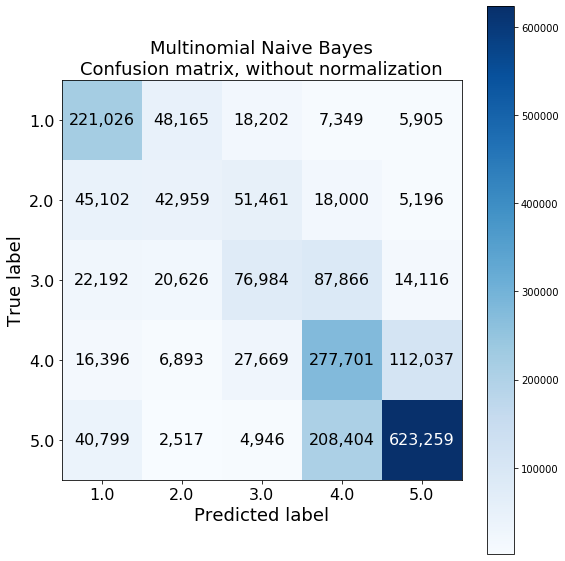

In [44]:
model_name = 'Multinomial Naive Bayes'
classes = [1.0, 2.0, 3.0, 4.0, 5.0]
plot_confusion_matrix(y_test, y_pred_mnb, classes, model_name, width=8)

Multinomial Naive Bayes
Normalized confusion matrix
[[0.73516782 0.16020449 0.06054276 0.02444395 0.01964097]
 [0.27717892 0.2640089  0.3162588  0.11062083 0.03193255]
 [0.10006132 0.0930004  0.34711251 0.39617826 0.06364751]
 [0.03720479 0.01564117 0.06278478 0.63014187 0.2542274 ]
 [0.04636645 0.00286047 0.00562093 0.23684291 0.70830923]]


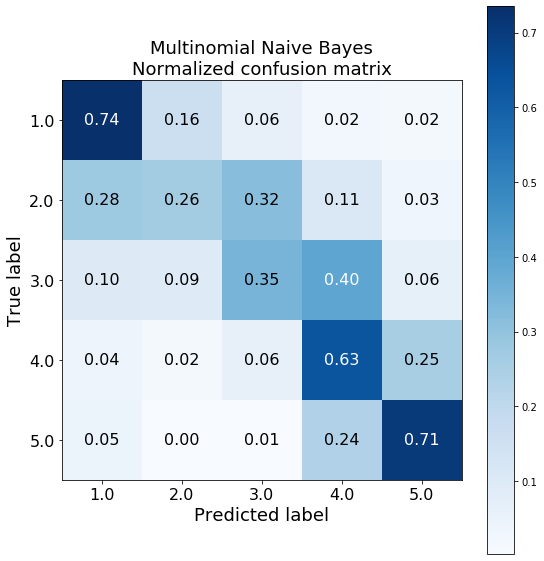

In [45]:
model_name = 'Multinomial Naive Bayes'
classes = [1.0, 2.0, 3.0, 4.0, 5.0]
plot_confusion_matrix(y_test, y_pred_mnb, classes, model_name, width=8, normalize=True)

In [50]:
multinb_bow_gs_results = pd.DataFrame(gs_multinb_bow.cv_results_)
multinb_bow_gs_results.to_csv(gs_results_dir + 'gs_multinb_bow.csv', index=False)
print("DataFrame with grid search results recorded to a .csv file")

DataFrame with grid search results recorded to a .csv file


### Complement Naive Bayes

In [8]:
t = time()

bow = CountVectorizer(ngram_range=(1,1), tokenizer=tokenizer)

complnb_tfidf = Pipeline([('vect', bow), ('clf', ComplementNB())])

complnb_tfidf.fit(X_train, y_train)

y_pred = complnb_tfidf.predict(X_test)

elapsed = time() - t

print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
print(classification_report(y_test, y_pred))

Model fit, took 663.00 seconds (11.05 minutes)
              precision    recall  f1-score   support

         1.0       0.55      0.89      0.68    300647
         2.0       0.44      0.08      0.13    162718
         3.0       0.43      0.16      0.24    221784
         4.0       0.46      0.51      0.48    440696
         5.0       0.78      0.81      0.80    879925

    accuracy                           0.63   2005770
   macro avg       0.53      0.49      0.47   2005770
weighted avg       0.61      0.63      0.59   2005770



### Logistic Regression

In [8]:
t = time()

bow = CountVectorizer(ngram_range=(1,1), tokenizer=tokenizer)

lr_tfidf = Pipeline([('vect', bow), ('clf', LogisticRegression(random_state=random_state, verbose=1,
                                                               solver='lbfgs', multi_class='ovr',
                                                               penalty='l2', C=1.0, n_jobs=-1))])

lr_tfidf.fit(X_train, y_train)

y_pred = lr_tfidf.predict(X_test)

elapsed = time() - t

print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/p

Model fit, took 4,454.82 seconds (74.25 minutes)
              precision    recall  f1-score   support

         1.0       0.74      0.85      0.79    300647
         2.0       0.52      0.23      0.32    162718
         3.0       0.53      0.34      0.41    221784
         4.0       0.53      0.42      0.47    440696
         5.0       0.73      0.91      0.81    879925

    accuracy                           0.68   2005770
   macro avg       0.61      0.55      0.56   2005770
weighted avg       0.65      0.68      0.65   2005770

